# Neural Architecture Search and Deep Ensemble with Uncertainty Quantification for Regression (Pytorch)

In this tutorial, you will learn how to perform **Neural Architecture Search (NAS)** and use it to construct a diverse deep ensemble with disentangled **aleatoric** and **epistemic uncertainty**.

NAS is a technique for automatically exploring and optimizing the architecture of deep neural networks to solve a given task. Here, we will use **hyperparameter optimization (HPO)** algorithms to guide the NAS process.

Specifically, in this tutorial you will learn how to:
1.	**Define a customizable PyTorch module** that exposes neural architecture hyperparameters.
2.	**Constrain the hyperparameter search space** to reduce redundancies and improve efficiency by breaking symmetry in the search space.

This tutorial will provide a hands-on approach to leveraging NAS for robust regression models with well-calibrated uncertainty estimates.

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split


WIDTH_PLOTS = 8
HEIGHT_PLOTS = WIDTH_PLOTS / 1.618

## Dataset

We generate synthetic data from a 1D scalar function $Y = f(X) + \epsilon(X)$, where $X,Y$ are random variables with support $\mathbb{R}$.

The training data are drown uniformly from $X \sim U([-30,-15] \cup [15,30])$.

$$ f(x) = \cos(x/2) + 2 \cdot \sin(x/10) + x/100$$

and $\epsilon(X) \sim \mathcal{N}(0, \sigma(X))$ with:
- $\sigma(x) = 0.5$ if $x \in [-30,-15]$
- $\sigma(x) = 1$ if $x \in [15,30]$

In [2]:
def load_data(
    developement_size=500,
    test_size=200,
    random_state=42,
    x_min=-50,
    x_max=50,
):
    rs = np.random.RandomState(random_state)

    def f(x):
        return np.cos(x / 2) + 2 * np.sin(x / 10) + x / 100

    x_1 = rs.uniform(low=-30, high=-15.0, size=developement_size // 2)
    eps_1 = rs.normal(loc=0.0, scale=0.5, size=developement_size // 2)
    y_1 = f(x_1) + eps_1

    x_2 = rs.uniform(low=15.0, high=30.0, size=developement_size // 2)
    eps_2 = rs.normal(loc=0.0, scale=1.0, size=developement_size // 2)
    y_2 = f(x_2) + eps_2

    x = np.concatenate([x_1, x_2], axis=0)
    y = np.concatenate([y_1, y_2], axis=0)

    test_X = np.linspace(x_min, x_max, test_size)
    test_y = f(test_X)

    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    train_X, valid_X, train_y, valid_y = train_test_split(
        x, y, test_size=0.33, random_state=random_state
    )

    test_X = test_X.reshape(-1, 1)
    test_y = test_y.reshape(-1, 1)

    return (train_X, train_y), (valid_X, valid_y), (test_X, test_y)


(train_X, train_y), (valid_X, valid_y), (test_X, test_y) = load_data()

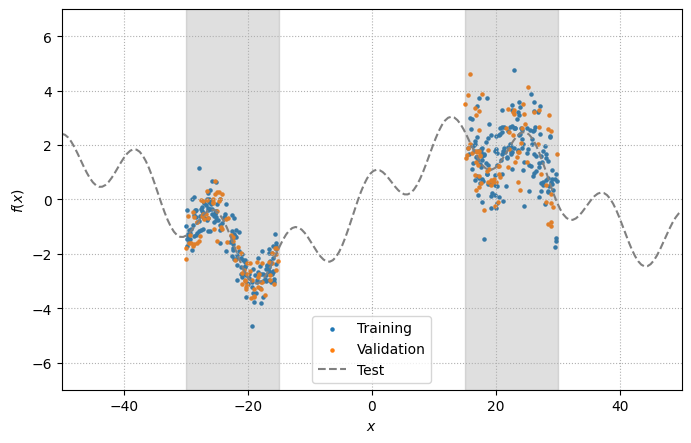

In [3]:
plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
plt.scatter(train_X, train_y, s=5, label="Training")
plt.scatter(valid_X, valid_y, s=5, label="Validation")
plt.plot(test_X, test_y, linestyle="--", color="gray", label="Test")

x_lim, y_lim = 50, 7
plt.fill_between([-30, -15], [-y_lim, -y_lim], [y_lim, y_lim], color="gray", alpha=0.25)
plt.fill_between([15, 30], [-y_lim, -y_lim], [y_lim, y_lim], color="gray", alpha=0.25)
plt.xlim(-x_lim, x_lim)
plt.ylim(-y_lim, y_lim)
plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(which="both", linestyle=":")
plt.show()

## Configurable Deep Neural Network with Aleatoric Uncertainty

Then, we define a configurable Pytorch module to explore:
- the number of layers
- the number of units per layer
- the activation function per layer
- the dropout rate

The output of this module will be a Gaussian distribution $\mathcal{N}(\mu_\theta(x), \sigma_\theta(x))$, where $\theta$ represent the concatenation of weights and hyperparameters of our model.

In [4]:
import torch
import torch.nn as nn

from torch.utils.data import DataLoader, TensorDataset

In [5]:
class DeepNormalRegressor(nn.Module):
    def __init__(
        self,
        n_inputs,
        layers,
        n_units_mean=64,
        n_units_std=64,
        std_offset=1e-3,
        softplus_factor=0.05,
        loc=0,
        scale=1.0,
    ):
        super().__init__()

        layers_ = []
        prev_n_units = n_inputs
        for n_units, activation, dropout_rate in layers:
            linear_layer = nn.Linear(prev_n_units, n_units)
            if activation == "relu":
                activation_layer = nn.ReLU()
            elif activation == "sigmoid":
                activation_layer = nn.Sigmoid()
            elif activation == "tanh":
                activation_layer = nn.Tanh()
            elif activation == "swish":
                activation_layer = nn.SiLU()
            elif activation == "mish":
                activation_layer = nn.Mish()
            elif activation == "gelu":
                activation_layer = nn.GELU()
            elif activation == "silu":
                activation_layer = nn.SiLU()
            dropout_layer = nn.Dropout(dropout_rate)

            layers_.extend([linear_layer, activation_layer, dropout_layer])

            prev_n_units = n_units

        # Shared parameters
        self.shared_layer = nn.Sequential(
            *layers_,
        )

        # Mean parameters
        self.mean_layer = nn.Sequential(
            nn.Linear(prev_n_units, n_units_mean),
            nn.ReLU(),
            nn.Linear(n_units_mean, 1),
        )

        # Standard deviation parameters
        self.std_layer = nn.Sequential(
            nn.Linear(prev_n_units, n_units_std),
            nn.ReLU(),
            nn.Linear(n_units_std, 1),
            nn.Softplus(beta=1.0, threshold=20.0),  # enforces positivity
        )

        self.std_offset = std_offset
        self.softplus_factor = softplus_factor
        self.loc = loc
        self.scale = scale

    def forward(self, x):
        # Shared embedding
        shared = self.shared_layer(x)

        # Parametrization of the mean
        mu = self.mean_layer(shared) + self.loc

        # Parametrization of the standard deviation
        sigma = (
            self.std_offset + self.std_layer(self.softplus_factor * shared) * self.scale
        )

        return torch.distributions.Normal(mu, sigma)


## Neural Architecture Search Space

In [47]:
from ConfigSpace import GreaterThanCondition
from deephyper.hpo import HpProblem


def create_hpo_problem(max_num_layers=10):
    problem = HpProblem()

    # Neural Architecture Hyperparameters
    num_layers = problem.add_hyperparameter(
        (1, max_num_layers), "num_layers", default_value=5
    )

    conditions = []
    for i in range(max_num_layers):
        layer_i_units = problem.add_hyperparameter(
            (16, 200), f"layer_{i}_units", default_value=64
        )
        layer_i_activation = problem.add_hyperparameter(
            ["relu", "sigmoid", "tanh", "swish", "mish", "gelu", "silu"],
            f"layer_{i}_activation",
            default_value="relu",
        )
        layer_i_dropout_rate = problem.add_hyperparameter(
            (0.0, 0.25), f"layer_{i}_dropout_rate", default_value=0.0
        )

        if i > 0:
            conditions.extend(
                [
                    GreaterThanCondition(layer_i_units, num_layers, i),
                    GreaterThanCondition(layer_i_activation, num_layers, i),
                    GreaterThanCondition(layer_i_dropout_rate, num_layers, i),
                ]
            )

    problem.add_conditions(conditions)

    problem.add_hyperparameter((16, 200), "n_units_mean", default_value=64)
    problem.add_hyperparameter((16, 200), "n_units_std", default_value=64)
    problem.add_hyperparameter(
        (1e-8, 1e-2, "log-uniform"), "std_offset", default_value=1e-3
    )
    problem.add_hyperparameter((0.01, 1.0), "softplus_factor", default_value=0.05)

    # Training Hyperparameters
    problem.add_hyperparameter(
        (1e-5, 1e-1, "log-uniform"), "learning_rate", default_value=2e-3
    )
    problem.add_hyperparameter((8, 256, "log-uniform"), "batch_size", default_value=128)
    problem.add_hyperparameter((0.1, 0.99), "lr_scheduler_factor", default_value=0.1)
    problem.add_hyperparameter((10, 100), "lr_scheduler_patience", default_value=20)

    return problem


In [48]:
problem = create_hpo_problem()
problem

Configuration space object:
  Hyperparameters:
    batch_size, Type: UniformInteger, Range: [8, 256], Default: 128, on log-scale
    layer_0_activation, Type: Categorical, Choices: {relu, sigmoid, tanh, swish, mish, gelu, silu}, Default: relu
    layer_0_dropout_rate, Type: UniformFloat, Range: [0.0, 0.25], Default: 0.0
    layer_0_units, Type: UniformInteger, Range: [16, 200], Default: 64
    layer_1_activation, Type: Categorical, Choices: {relu, sigmoid, tanh, swish, mish, gelu, silu}, Default: relu
    layer_1_dropout_rate, Type: UniformFloat, Range: [0.0, 0.25], Default: 0.0
    layer_1_units, Type: UniformInteger, Range: [16, 200], Default: 64
    layer_2_activation, Type: Categorical, Choices: {relu, sigmoid, tanh, swish, mish, gelu, silu}, Default: relu
    layer_2_dropout_rate, Type: UniformFloat, Range: [0.0, 0.25], Default: 0.0
    layer_2_units, Type: UniformInteger, Range: [16, 200], Default: 64
    layer_3_activation, Type: Categorical, Choices: {relu, sigmoid, tanh, swish

## Loss and Metric

In [32]:
def nll(y, rv_y):
    """Negative log likelihood for Pytorch distribution.

    Args:
        y: true data.
        rv_y: learned (predicted) probability distribution.
    """
    return -rv_y.log_prob(y)


def squared_error(y_true, rv_y):
    """Squared error for Pytorch distribution.

    Args:
        y: true data.
        rv_y: learned (predicted) probability distribution.
    """
    y_pred = rv_y.mean
    return (y_true - y_pred) ** 2

## Training Loop

In [40]:
from tqdm.notebook import tqdm


def train_one_step(model, optimizer, x_batch, y_batch):
    model.train()
    optimizer.zero_grad()
    y_dist = model(x_batch)

    loss = torch.mean(nll(y_batch, y_dist))
    mse = torch.mean(squared_error(y_batch, y_dist))

    loss.backward()
    optimizer.step()

    return loss, mse


def train(
    model,
    optimizer,
    x_train,
    x_val,
    y_train,
    y_val,
    n_epochs,
    batch_size,
    scheduler=None,
    patience=200,
    progressbar=True,
):
    data_train = DataLoader(
        TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True
    )

    checkpointed_state_dict = model.state_dict()
    checkpointed_val_loss = np.inf

    train_loss, val_loss = [], []
    train_mse, val_mse = [], []

    tqdm_bar = tqdm(total=n_epochs, disable=not progressbar)

    for epoch in range(n_epochs):
        batch_losses_t, batch_losses_v, batch_mse_t, batch_mse_v = [], [], [], []

        for batch_x, batch_y in data_train:
            b_train_loss, b_train_mse = train_one_step(
                model, optimizer, batch_x, batch_y
            )

            model.eval()
            y_dist = model(x_val)
            b_val_loss = torch.mean(nll(y_val, y_dist))
            b_val_mse = torch.mean(squared_error(y_val, y_dist))

            batch_losses_t.append(b_train_loss.detach().numpy())
            batch_mse_t.append(b_train_mse.detach().numpy())
            batch_losses_v.append(b_val_loss.detach().numpy())
            batch_mse_v.append(b_val_mse.detach().numpy())

        train_loss.append(np.mean(batch_losses_t))
        val_loss.append(np.mean(batch_losses_v))
        train_mse.append(np.mean(batch_mse_t))
        val_mse.append(np.mean(batch_mse_v))

        if scheduler is not None:
            scheduler.step(val_loss[-1])

        tqdm_bar.update(1)
        tqdm_bar.set_postfix(
            {
                "train_loss": f"{train_loss[-1]:.3f}",
                "val_loss": f"{val_loss[-1]:.3f}",
                "train_mse": f"{train_mse[-1]:.3f}",
                "val_mse": f"{val_mse[-1]:.3f}",
            }
        )

        # Checkpoint weights if they improve
        if val_loss[-1] < checkpointed_val_loss:
            checkpointed_val_loss = val_loss[-1]
            checkpointed_state_dict = model.state_dict()

        if len(val_loss) > (patience + 1) and val_loss[-patience - 1] < min(
            val_loss[-patience:]
        ):
            break

    # Reload the best weights
    model.load_state_dict(checkpointed_state_dict)

    return train_loss, val_loss, train_mse, val_mse

## Evaluation Function

In [49]:
def run(job, model_checkpoint_dir=".", verbose=False):
    (x, y), (vx, vy), (tx, ty) = load_data()

    y_mu = np.mean(y)
    y_std = np.std(y)

    inputs = x.shape[1]

    num_layers = job.parameters["num_layers"]
    model = DeepNormalRegressor(
        inputs,
        layers=[
            (
                job.parameters[f"layer_{i}_units"],
                job.parameters[f"layer_{i}_activation"],
                job.parameters[f"layer_{i}_dropout_rate"],
            )
            for i in range(num_layers)
        ],
        loc=y_mu,
        scale=y_std,
    )

    if verbose:
        print(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=job.parameters["learning_rate"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        factor=job.parameters["lr_scheduler_factor"],
        patience=job.parameters["lr_scheduler_patience"],
    )

    x = torch.from_numpy(x).float()
    vx = torch.from_numpy(vx).float()
    tx = torch.from_numpy(tx).float()

    y = torch.from_numpy(y).float()
    vy = torch.from_numpy(vy).float()
    ty = torch.from_numpy(ty).float()

    try:
        train_losses, val_losses, train_mse, val_mse = train(
            model,
            optimizer,
            x,
            vx,
            y,
            vy,
            n_epochs=1000,
            batch_size=job.parameters["batch_size"],
            scheduler=scheduler,
            progressbar=verbose,
        )
    except Exception:
        return "F_fit"

    ty_pred = model(tx)
    test_loss = torch.mean(nll(ty, ty_pred)).detach().numpy()
    test_mse = torch.mean(squared_error(ty, ty_pred)).detach().numpy()

    # Saving the model
    torch.save(
        model.state_dict(), os.path.join(model_checkpoint_dir, f"model_{job.id}.pt")
    )

    return {
        "objective": -val_losses[-1],
        "metadata": {
            "train_loss": train_losses,
            "val_loss": val_losses,
            "train_mse": train_mse,
            "val_mse": val_mse,
            "test_loss": test_loss,
            "test_mse": test_mse,
        },
    }

## Evaluation of the Baseline Neural Architecture

In [50]:
from deephyper.evaluator import RunningJob


def evaluate_baseline():
    model_checkpoint_dir = "nas_baseline_regression/models"
    pathlib.Path(model_checkpoint_dir).mkdir(parents=True, exist_ok=True)

    problem = create_hpo_problem()

    default_parameters = problem.default_configuration
    print(f"{default_parameters=}\n")

    result = run(
        RunningJob(parameters=default_parameters),
        model_checkpoint_dir=model_checkpoint_dir,
        verbose=True,
    )
    return result


In [51]:
baseline_results = evaluate_baseline()

default_parameters={'batch_size': 128, 'layer_0_activation': 'relu', 'layer_0_dropout_rate': 0.0, 'layer_0_units': 64, 'learning_rate': 0.002, 'lr_scheduler_factor': 0.1, 'lr_scheduler_patience': 20, 'n_units_mean': 64, 'n_units_std': 64, 'num_layers': 5, 'softplus_factor': 0.05, 'std_offset': 0.001, 'layer_1_activation': 'relu', 'layer_1_dropout_rate': 0.0, 'layer_1_units': 64, 'layer_2_activation': 'relu', 'layer_2_dropout_rate': 0.0, 'layer_2_units': 64, 'layer_3_activation': 'relu', 'layer_3_dropout_rate': 0.0, 'layer_3_units': 64, 'layer_4_activation': 'relu', 'layer_4_dropout_rate': 0.0, 'layer_4_units': 64, 'layer_5_activation': 'relu', 'layer_5_dropout_rate': 0.0, 'layer_5_units': 16, 'layer_6_activation': 'relu', 'layer_6_dropout_rate': 0.0, 'layer_6_units': 16, 'layer_7_activation': 'relu', 'layer_7_dropout_rate': 0.0, 'layer_7_units': 16, 'layer_8_activation': 'relu', 'layer_8_dropout_rate': 0.0, 'layer_8_units': 16, 'layer_9_activation': 'relu', 'layer_9_dropout_rate': 0.0,

  0%|          | 0/1000 [00:00<?, ?it/s]

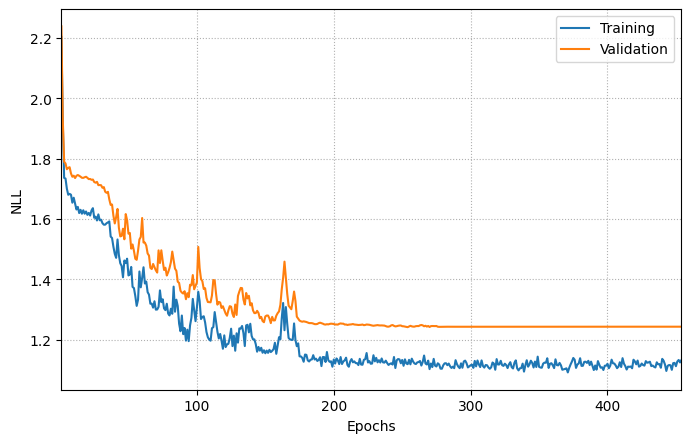

In [52]:
plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))

x_values = np.arange(1, len(baseline_results["metadata"]["train_loss"]) + 1)
plt.plot(
    x_values,
    baseline_results["metadata"]["train_loss"],
    label="Training",
)
plt.plot(
    x_values,
    baseline_results["metadata"]["val_loss"],
    label="Validation",
)

plt.xlim(x_values.min(), x_values.max())
plt.grid(which="both", linestyle=":")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("NLL")
plt.show()

In [55]:
hpo_dir = "nas_baseline_regression"
model_checkpoint_dir = os.path.join(hpo_dir, "models")
file_name = "model_0.0.pt"

y_mu, y_std = np.mean(train_y), np.std(train_y)
inputs = train_X.shape[1]

weights_path = os.path.join(model_checkpoint_dir, file_name)
job_id = int(file_name[6:-3].split(".")[-1])

parameters = problem.default_configuration

num_layers = parameters["num_layers"]
torch_module = DeepNormalRegressor(
    inputs,
    layers=[
        (
            parameters[f"layer_{i}_units"],
            parameters[f"layer_{i}_activation"],
            parameters[f"layer_{i}_dropout_rate"],
        )
        for i in range(num_layers)
    ],
    loc=y_mu,
    scale=y_std,
)

torch_module.load_state_dict(torch.load(weights_path, weights_only=True))
torch_module.eval()

y_pred = torch_module.forward(torch.from_numpy(test_X).float())
y_pred_mean = y_pred.loc.detach().numpy()
y_pred_std = y_pred.scale.detach().numpy()

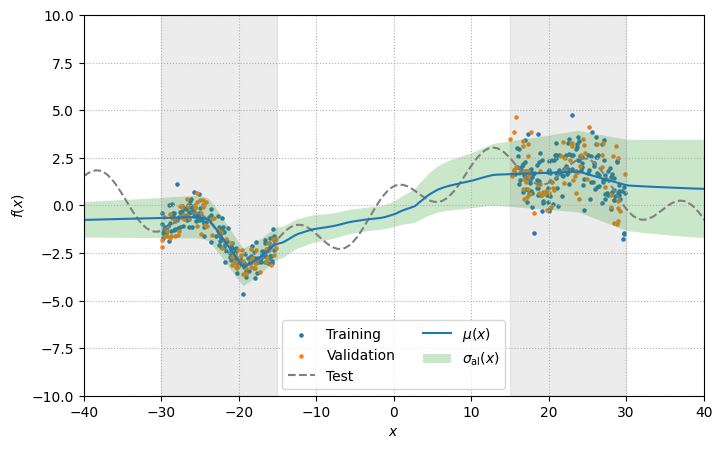

In [56]:
plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
plt.scatter(train_X, train_y, s=5, label="Training")
plt.scatter(valid_X, valid_y, s=5, label="Validation")
plt.plot(test_X, test_y, linestyle="--", color="gray", label="Test")

plt.plot(test_X, y_pred_mean, label=r"$\mu(x)$")
kappa = 1.96
plt.fill_between(
    test_X.reshape(-1),
    (y_pred_mean - kappa * y_pred_std).reshape(-1),
    (y_pred_mean + kappa * y_pred_std).reshape(-1),
    alpha=0.25,
    label=r"$\sigma_\text{al}(x)$",
)

x_lim, y_lim = 40, 10
plt.fill_between([-30, -15], [-y_lim, -y_lim], [y_lim, y_lim], color="gray", alpha=0.15)
plt.fill_between([15, 30], [-y_lim, -y_lim], [y_lim, y_lim], color="gray", alpha=0.15)
plt.xlim(-x_lim, x_lim)
plt.ylim(-y_lim, y_lim)
plt.legend(ncols=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(which="both", linestyle=":")
plt.show()

## Running the Neural Architecture Search

In [57]:
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import TqdmCallback
from deephyper.hpo import CBO


def run_neural_architecture_search(problem):
    hpo_dir = "nas_regression"
    model_checkpoint_dir = os.path.join(hpo_dir, "models")
    pathlib.Path(model_checkpoint_dir).mkdir(parents=True, exist_ok=True)

    evaluator = Evaluator.create(
        run,
        method="ray", # "thread"
        method_kwargs={ # "num_workers": 1
            "num_cpus": 8,
            "num_cpus_per_task": 1,
            "run_function_kwargs": {
                "model_checkpoint_dir": model_checkpoint_dir,
                "verbose": False,
            },
            "callbacks": [TqdmCallback()],
        },
    )

    search_kwargs = {
        "initial_points": [problem.default_configuration],
        "n_initial_points": 2 * len(problem) + 1,  # Number of initial random points
        "surrogate_model": "ET",  # Use Extra Trees as surrogate model
        "surrogate_model_kwargs": {
            "n_estimators": 50,  # Relatively small number of trees in the surrogate to make it "fast"
            "min_samples_split": 8,  # Larger number to avoid small leaf nodes (smoothing the response)
        },
        "multi_point_strategy": "qUCBd",  # Multi-point strategy for asynchronous batch generations (explained later)
        "acq_optimizer": "mixedga",  # Use continuous Genetic Algorithm for the acquisition function optimizer
        "acq_optimizer_freq": 1,  # Frequency of the acquisition function optimizer (1 = each new batch generation) increasing this value can help amortize the computational cost of acquisition function optimization
        "filter_duplicated": False,  # Deactivate filtration of duplicated new points
        "kappa": 10.0,  # Initial value of exploration-exploitation parameter for the acquisition function
        "scheduler": {  # Scheduler for the exploration-exploitation parameter "kappa"
            "type": "periodic-exp-decay",  # Periodic exponential decay
            "period": 50,  # Period over which the decay is applied. It is useful to escape local solutions.
            "kappa_final": 0.001,  # Value of kappa at the end of each "period"
        },
        "objective_scaler": "identity",
        "random_state": 42,  # Random seed
    }
    search = CBO(problem, evaluator, log_dir=hpo_dir, **search_kwargs)

    results = search.search(max_evals=200)

    return results

In [58]:
hpo_results = run_neural_architecture_search(problem)

2025-02-03 15:46:54,766	INFO worker.py:1819 -- Started a local Ray instance.
/Users/romainegele/Documents/Argonne/deephyper/src/deephyper/evaluator/_evaluator.py:148: UserWarning: Applying nest-asyncio patch for IPython Shell!
  warnings.warn("Applying nest-asyncio patch for IPython Shell!", category=UserWarning)


  0%|          | 0/200 [00:00<?, ?it/s]

## Analysing the Neural Architecture Search Results

In [61]:
import json

from deephyper.analysis.hpo import filter_failed_objectives
from deephyper.analysis.hpo import parameters_from_row
from deephyper.analysis.hpo import plot_search_trajectory_single_objective_hpo
from deephyper.analysis.hpo import plot_worker_utilization

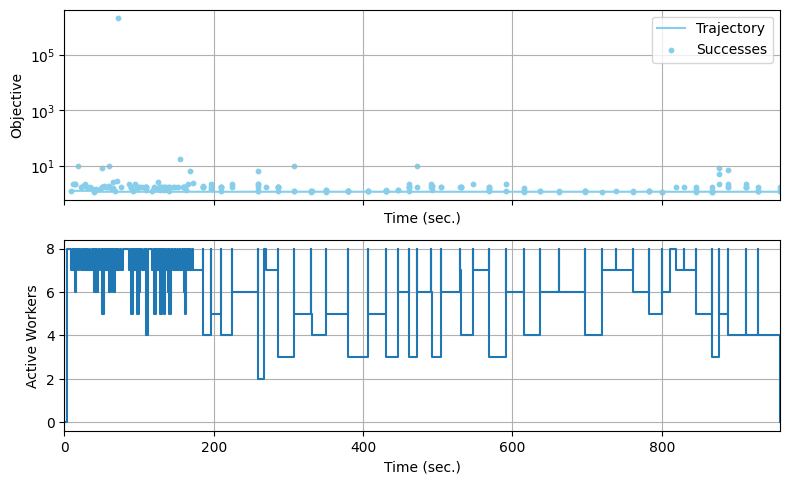

In [62]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=True,
    figsize=(WIDTH_PLOTS, HEIGHT_PLOTS),
)

plot_search_trajectory_single_objective_hpo(
    hpo_results,
    mode="min",
    x_units="seconds",
    ax=axes[0],
)
axes[0].set_yscale("log")

plot_worker_utilization(
    hpo_results,
    profile_type="submit/gather",
    ax=axes[1],
)

plt.tight_layout()
plt.show()

In [63]:
hpo_results, hpo_results_failed = filter_failed_objectives(hpo_results)

hpo_results

,p:batch_size,p:layer_0_activation,p:layer_0_dropout_rate,p:layer_0_units,p:learning_rate,p:lr_scheduler_factor,p:lr_scheduler_patience,p:n_units_mean,p:n_units_std,p:num_layers,...,job_id,job_status,m:timestamp_submit,m:train_loss,m:val_loss,m:train_mse,m:val_mse,m:test_loss,m:test_mse,m:timestamp_gather
0,128,relu,0.000000,64,0.002000,0.100000,20,64,64,5,...,0,DONE,3.202641,"[2.0910132, 1.925398, 1.8237976, 1.7256943, 1....","[2.1447055, 1.9763222, 1.8717371, 1.7818133, 1...","[3.394952, 2.6946614, 2.2346172, 1.7752957, 1....","[3.6550987, 2.9341629, 2.464535, 2.041674, 2.0...",3.746189,2.561725,8.262724
1,68,gelu,0.163604,69,0.088403,0.807050,24,123,129,10,...,5,DONE,3.209867,"[28.937588, 6.6798925, 6.775415, 6.7050233, 6....","[19.138828, 6.932672, 6.5458403, 6.6197844, 5....","[2693.4243, 32816.918, 13419.717, 9120.943, 35...","[3204.7017, 37695.57, 4138.695, 6422.0312, 531...",1.913984,2.502487,11.177275
2,70,swish,0.188654,184,0.052663,0.451413,59,165,120,10,...,2,DONE,3.205637,"[9.863289, 6.6142135, 6.872327, 7.18646, 7.612...","[10.508951, 6.7822905, 6.2527857, 7.337262, 7....","[1768.1461, 9913.693, 5217.5015, 68319.66, 339...","[3361.3242, 10902.835, 7570.081, 69408.81, 277...",1.914400,2.502334,13.582748
3,119,silu,0.246973,132,0.000251,0.330596,76,113,100,9,...,1,DONE,3.204195,"[2.2339065, 2.2146142, 2.2105675, 2.2082083, 2...","[2.3570526, 2.3497307, 2.3429608, 2.3351328, 2...","[3.7907581, 3.740019, 3.7487385, 3.7640584, 3....","[4.2716813, 4.27441, 4.27902, 4.2786374, 4.265...",2.613307,2.684479,13.597396
4,11,sigmoid,0.142795,143,0.080070,0.119921,73,104,84,3,...,3,DONE,3.207079,"[7.0758905, 6.4870086, 9.416236, 8.060884, 8.0...","[8.591235, 6.3422117, 7.134895, 8.082564, 8.09...","[2234.7808, 8482.481, 22670.521, 34157.703, 34...","[2000.675, 8392.84, 21945.557, 34427.918, 3393...",9.631887,12114.553000,17.490827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,65,tanh,0.022422,63,0.000381,0.481418,78,126,134,2,...,200,DONE,913.201856,"[2.249364, 1.9719805, 1.7420558, 1.6125022, 1....","[2.3150518, 2.0433376, 1.8357135, 1.7033653, 1...","[3.6535232, 2.7181199, 1.9033537, 1.429339, 1....","[3.8912265, 2.977341, 2.2468257, 1.7661101, 1....",7.530803,4.581821,928.908911
201,26,tanh,0.014442,131,0.001772,0.759655,85,169,41,2,...,203,DONE,928.831515,"[1.7747225, 1.5880623, 1.5289865, 1.5371445, 1...","[1.7459984, 1.6548083, 1.6196666, 1.6305588, 1...","[1.9707952, 1.3646811, 1.2211498, 1.263088, 1....","[1.8930752, 1.6015567, 1.4942756, 1.5087497, 1...",3.559857,2.047078,958.323615
202,26,tanh,0.014442,131,0.001772,0.759655,85,169,41,2,...,202,DONE,928.829442,"[1.7539233, 1.5811946, 1.5476693, 1.5820615, 1...","[1.7681298, 1.6600188, 1.6433537, 1.6486593, 1...","[1.9200137, 1.3182247, 1.276723, 1.3703933, 1....","[1.99201, 1.5996583, 1.5279138, 1.5441989, 1.5...",4.296856,2.447181,958.346293
203,13,sigmoid,0.031354,196,0.003110,0.257463,91,190,21,8,...,201,DONE,928.827149,"[2.0076232, 1.6351836, 1.5680751, 1.6120033, 1...","[2.0858042, 1.7115028, 1.6584094, 1.7023711, 1...","[2.9326587, 1.4358798, 1.3216627, 1.4589157, 1...","[3.3043845, 1.7489052, 1.5848994, 1.7391242, 1...",2.428832,3.441845,958.368967


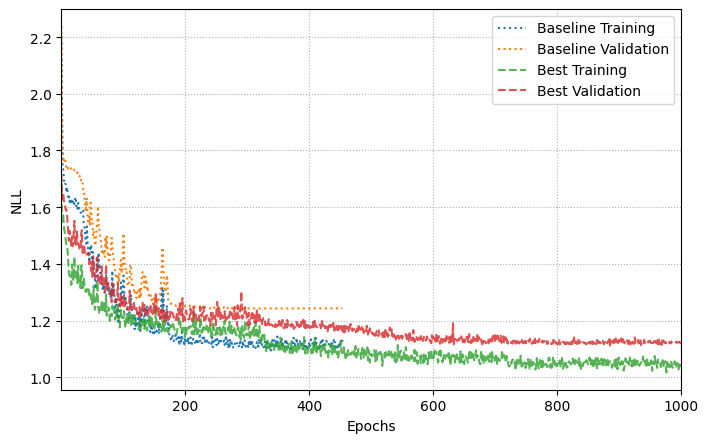

In [64]:
plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))

x_values = np.arange(1, len(baseline_results["metadata"]["train_loss"]) + 1)
plt.plot(
    x_values,
    baseline_results["metadata"]["train_loss"],
    linestyle=":",
    label="Baseline Training",
)
plt.plot(
    x_values,
    baseline_results["metadata"]["val_loss"],
    linestyle=":",
    label="Baseline Validation",
)

i_max = hpo_results["objective"].argmax()
train_loss = json.loads(hpo_results.iloc[i_max]["m:train_loss"])
val_loss = json.loads(hpo_results.iloc[i_max]["m:val_loss"])

x_values = np.arange(1, len(train_loss) + 1)
plt.plot(
    x_values,
    train_loss,
    alpha=0.8,
    linestyle="--",
    label="Best Training",
)
plt.plot(
    x_values,
    val_loss,
    alpha=0.8,
    linestyle="--",
    label="Best Validation",
)
plt.xlim(x_values.min(), x_values.max())
plt.grid(which="both", linestyle=":")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("NLL")
plt.show()

In [65]:
hpo_dir = "nas_regression"
model_checkpoint_dir = os.path.join(hpo_dir, "models")
job_id = hpo_results.iloc[i_max]["job_id"]
file_name = f"model_0.{job_id}.pt"

y_mu, y_std = np.mean(train_y), np.std(train_y)
inputs = train_X.shape[1]

weights_path = os.path.join(model_checkpoint_dir, file_name)
parameters = parameters_from_row(hpo_results.iloc[i_max])

num_layers = parameters["num_layers"]
torch_module = DeepNormalRegressor(
    inputs,
    layers=[
        (
            parameters[f"layer_{i}_units"],
            parameters[f"layer_{i}_activation"],
            parameters[f"layer_{i}_dropout_rate"],
        )
        for i in range(num_layers)
    ],
    loc=y_mu,
    scale=y_std,
)

torch_module.load_state_dict(torch.load(weights_path, weights_only=True))
torch_module.eval()

y_pred = torch_module.forward(torch.from_numpy(test_X).float())
y_pred_mean = y_pred.loc.detach().numpy()
y_pred_std = y_pred.scale.detach().numpy()

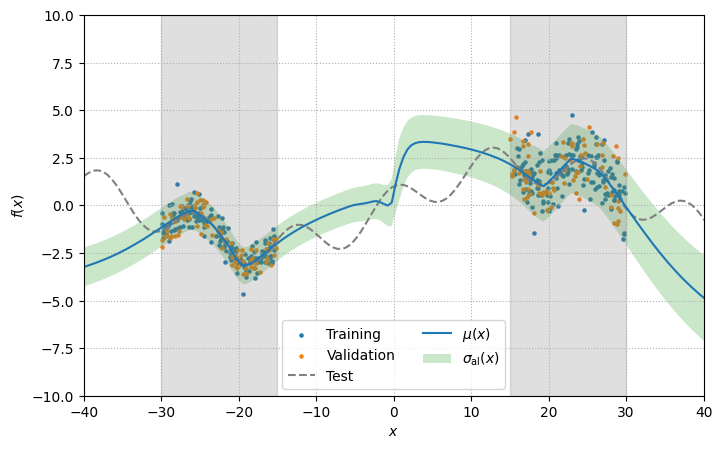

In [67]:
plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
plt.scatter(train_X, train_y, s=5, label="Training")
plt.scatter(valid_X, valid_y, s=5, label="Validation")
plt.plot(test_X, test_y, linestyle="--", color="gray", label="Test")

plt.plot(test_X, y_pred_mean, label=r"$\mu(x)$")
kappa = 1.96
plt.fill_between(
    test_X.reshape(-1),
    (y_pred_mean - kappa * y_pred_std).reshape(-1),
    (y_pred_mean + kappa * y_pred_std).reshape(-1),
    alpha=0.25,
    label=r"$\sigma_\text{al}(x)$",
)

x_lim, y_lim = 40, 10
plt.fill_between([-30, -15], [-y_lim, -y_lim], [y_lim, y_lim], color="gray", alpha=0.25)
plt.fill_between([15, 30], [-y_lim, -y_lim], [y_lim, y_lim], color="gray", alpha=0.25)
plt.xlim(-x_lim, x_lim)
plt.ylim(-y_lim, y_lim)
plt.legend(ncols=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(which="both", linestyle=":")
plt.show()

## Deep Ensemble

In [68]:
import os

from deephyper.ensemble import EnsemblePredictor
from deephyper.ensemble.aggregator import MixedNormalAggregator
from deephyper.ensemble.loss import NormalNegLogLikelihood
from deephyper.ensemble.selector import GreedySelector, TopKSelector
from deephyper.predictor.torch import TorchPredictor

In [69]:
class NormalTorchPredictor(TorchPredictor):
    def __init__(self, torch_module):
        super().__init__(torch_module)

    def pre_process_inputs(self, X):
        X = super().pre_process_inputs(X).float()
        return X

    def post_process_predictions(self, y):
        y = {
            "loc": y.loc.detach().numpy(),
            "scale": y.scale.detach().numpy(),
        }
        return y

In [70]:
hpo_dir = "nas_regression"
model_checkpoint_dir = os.path.join(hpo_dir, "models")

y_mu, y_std = np.mean(train_y), np.std(train_y)
inputs = train_X.shape[1]

y_predictors = []
job_id_predictors = []

for file_name in tqdm(os.listdir(model_checkpoint_dir)):
    if not file_name.endswith(".pt"):
        continue

    weights_path = os.path.join(model_checkpoint_dir, file_name)
    job_id = int(file_name[6:-3].split(".")[-1])

    row = hpo_results[hpo_results["job_id"] == job_id]
    if len(row) == 0:
        continue
    assert len(row) == 1
    row = row.iloc[0]
    parameters = parameters_from_row(row)

    num_layers = parameters["num_layers"]
    torch_module = DeepNormalRegressor(
        inputs,
        layers=[
            (
                parameters[f"layer_{i}_units"],
                parameters[f"layer_{i}_activation"],
                parameters[f"layer_{i}_dropout_rate"],
            )
            for i in range(num_layers)
        ],
        loc=y_mu,
        scale=y_std,
    )

    try:
        torch_module.load_state_dict(torch.load(weights_path, weights_only=True))
    except RuntimeError:
        continue

    torch_module.eval()

    predictor = NormalTorchPredictor(torch_module)
    y_pred = predictor.predict(valid_X)
    y_predictors.append(y_pred)
    job_id_predictors.append(job_id)

  0%|          | 0/206 [00:00<?, ?it/s]

In [71]:
k = 50

# Use TopK or Greedy/Caruana
# selector = TopKSelector(
#     loss_func=NormalNegLogLikelihood(),
#     k=k,
# )

selector = GreedySelector(
    loss_func=NormalNegLogLikelihood(),
    aggregator=MixedNormalAggregator(),
    k=k,
    max_it=100,
    k_init=3,
    early_stopping=False,
    with_replacement=True,
    bagging=True,
    verbose=True,
)

selected_predictors_indexes, selected_predictors_weights = selector.select(
    valid_y,
    y_predictors,
)

print(f"{selected_predictors_indexes=}")
print(f"{selected_predictors_weights=}")

selected_predictors_job_ids = np.array(job_id_predictors)[selected_predictors_indexes]
selected_predictors_job_ids

print(f"{selected_predictors_job_ids=}")

Ensemble initialized with [191, 43, 45]
Step 1, ensemble is [191, 43, 45, 0]
Step 2, ensemble is [191, 43, 45, 0, 45]
Step 3, ensemble is [191, 43, 45, 0, 45, 16]
Step 4, ensemble is [191, 43, 45, 0, 45, 16, 135]
Step 5, ensemble is [191, 43, 45, 0, 45, 16, 135, 191]
Step 6, ensemble is [191, 43, 45, 0, 45, 16, 135, 191, 45]
Step 7, ensemble is [191, 43, 45, 0, 45, 16, 135, 191, 45, 191]
Step 8, ensemble is [191, 43, 45, 0, 45, 16, 135, 191, 45, 191, 45]
Step 9, ensemble is [191, 43, 45, 0, 45, 16, 135, 191, 45, 191, 45, 45]
Step 10, ensemble is [191, 43, 45, 0, 45, 16, 135, 191, 45, 191, 45, 45, 38]
Step 11, ensemble is [191, 43, 45, 0, 45, 16, 135, 191, 45, 191, 45, 45, 38, 16]
Step 12, ensemble is [191, 43, 45, 0, 45, 16, 135, 191, 45, 191, 45, 45, 38, 16, 191]
Step 13, ensemble is [191, 43, 45, 0, 45, 16, 135, 191, 45, 191, 45, 45, 38, 16, 191, 191]
Step 14, ensemble is [191, 43, 45, 0, 45, 16, 135, 191, 45, 191, 45, 45, 38, 16, 191, 191, 135]
Step 15, ensemble is [191, 43, 45, 0, 

In [72]:
predictors = []

hpo_dir = "nas_regression"
model_checkpoint_dir = os.path.join(hpo_dir, "models")

y_mu, y_std = np.mean(train_y), np.std(train_y)
inputs = train_X.shape[1]

for job_id in selected_predictors_job_ids:
    file_name = f"model_0.{job_id}.pt"

    weights_path = os.path.join(model_checkpoint_dir, file_name)

    row = hpo_results[hpo_results["job_id"] == job_id].iloc[0]
    parameters = parameters_from_row(row)

    num_layers = parameters["num_layers"]
    torch_module = DeepNormalRegressor(
        inputs,
        layers=[
            (
                parameters[f"layer_{i}_units"],
                parameters[f"layer_{i}_activation"],
                parameters[f"layer_{i}_dropout_rate"],
            )
            for i in range(num_layers)
        ],
        loc=y_mu,
        scale=y_std,
    )

    torch_module.load_state_dict(torch.load(weights_path, weights_only=True))
    torch_module.eval()
    predictor = NormalTorchPredictor(torch_module)
    predictors.append(predictor)

ensemble = EnsemblePredictor(
    predictors=predictors,
    weights=selected_predictors_weights,
    aggregator=MixedNormalAggregator(decomposed_scale=True),
)

y_pred = ensemble.predict(test_X)

## Aleatoric Uncertainty

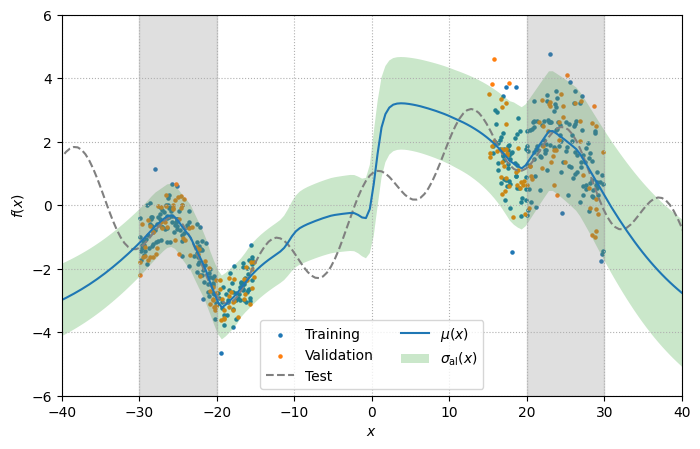

In [ ]:
plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
plt.scatter(train_X, train_y, s=5, label="Training")
plt.scatter(valid_X, valid_y, s=5, label="Validation")
plt.plot(test_X, test_y, linestyle="--", color="gray", label="Test")

plt.plot(test_X, y_pred["loc"], label=r"$\mu(x)$")
kappa = 1.96
plt.fill_between(
    test_X.reshape(-1),
    (y_pred["loc"] - kappa * y_pred["scale_aleatoric"]).reshape(-1),
    (y_pred["loc"] + kappa * y_pred["scale_aleatoric"]).reshape(-1),
    alpha=0.25,
    label=r"$\sigma_\text{al}(x)$",
)

x_lim, y_lim = 40, 6
plt.fill_between([-30, -15], [-y_lim, -y_lim], [y_lim, y_lim], color="gray", alpha=0.25)
plt.fill_between([15, 30], [-y_lim, -y_lim], [y_lim, y_lim], color="gray", alpha=0.25)
plt.xlim(-x_lim, x_lim)
plt.ylim(-y_lim, y_lim)
plt.legend(ncols=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(which="both", linestyle=":")
plt.show()

## Epistemic Uncertainty

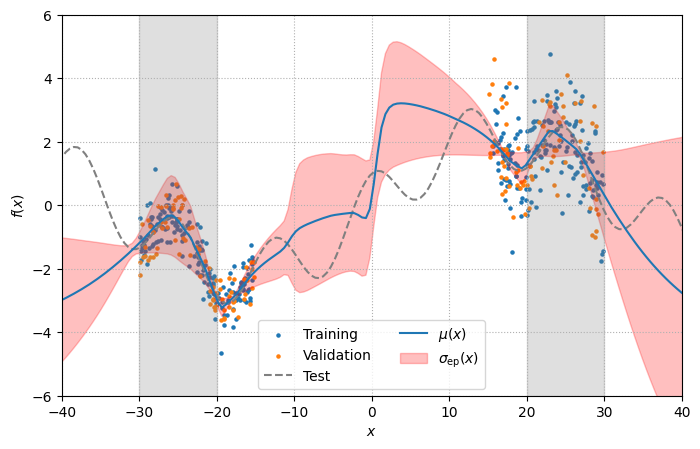

In [ ]:
plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
plt.scatter(train_X, train_y, s=5, label="Training")
plt.scatter(valid_X, valid_y, s=5, label="Validation")
plt.plot(test_X, test_y, linestyle="--", color="gray", label="Test")

plt.plot(test_X, y_pred["loc"], label=r"$\mu(x)$")
kappa = 1.96
plt.fill_between(
    test_X.reshape(-1),
    (y_pred["loc"] - kappa * y_pred["scale_epistemic"]).reshape(-1),
    (y_pred["loc"] + kappa * y_pred["scale_epistemic"]).reshape(-1),
    alpha=0.25,
    color="red",
    label=r"$\sigma_\text{ep}(x)$",
)

x_lim, y_lim = 40, 6
plt.fill_between([-30, -15], [-y_lim, -y_lim], [y_lim, y_lim], color="gray", alpha=0.25)
plt.fill_between([15, 30], [-y_lim, -y_lim], [y_lim, y_lim], color="gray", alpha=0.25)
plt.xlim(-x_lim, x_lim)
plt.ylim(-y_lim, y_lim)
plt.legend(ncols=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(which="both", linestyle=":")
plt.show()